In [1]:
version = "v1.8.100820"

---
# Assignment 3 Part 2: Multiple Time Series Forecasting (50 pts)

In this assignment, we're going to study forecasting and causality testing that involve multiple time series. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Suppress warnings
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter("ignore", ValueWarning)

We will explore the same five time series about **daily new COVID-19 cases for the top 5 countries with the most cumulative cases as of August 21, 2020** as we had in **Assignment 2 Part 2**. In order not to reinvent the suspension either, let's import the other `load_data` function you wrote previously. 

In [3]:
# Copy and paste the function you wrote in Assignment 2 Part 2 here and import any libraries necessary
# We have tried a more elegant solution by using
# from ipynb.fs.defs.assignment2_part2 import load_data
# but it doesn't work with the autograder...

def load_data():
    covid_df = pd.read_csv('assets/time_series_covid19_confirmed_global.csv')
    covid_df = covid_df.rename(columns={"Country/Region": " "})
    covid_df_transpose = covid_df.transpose()
    covid_df_transpose = covid_df_transpose.drop(labels = ['Province/State', 'Lat', 'Long'])
    new_header = covid_df_transpose.iloc[0] 
    covid_df_transpose =covid_df_transpose[1:] 
    covid_df_transpose.columns = new_header
    covid_df_transpose['Total_Cases_Per_Date'] =  covid_df_transpose[covid_df_transpose.columns].sum(axis=1)
    covid_df_transpose = covid_df_transpose.sort_values(covid_df_transpose.last_valid_index(), axis=1, ascending = False)
    covid_df_transpose = covid_df_transpose.drop(['Total_Cases_Per_Date'], axis=1)
    covid_df_transpose = covid_df_transpose.iloc[:,:5]
    covid_df_transpose.index = pd.to_datetime(covid_df_transpose.index)
    covid_df_transpose = covid_df_transpose.diff()
    covid_df_transpose = covid_df_transpose.fillna(0)
    covid_df_transpose = covid_df_transpose.apply(pd.to_numeric, downcast='float')
    covid_df_transpose =  covid_df_transpose.iloc[1:]

    
    
    return covid_df_transpose

In [4]:
# Sanity checks to make sure you have imported the correct function - no points awarded

stu_ans = load_data()

assert isinstance(stu_ans, pd.DataFrame), "Q0: Your function should return a pd.DataFrame. "
assert stu_ans.shape == (212, 5), "Q0: The shape of your pd.DataFrame returned is incorrect. "
assert isinstance(stu_ans.index, pd.DatetimeIndex), "Q0: The index of your pd.DataFrame must be a pd.DatetimeIndex. "
assert (("2020-01-23" <= stu_ans.index) & (stu_ans.index <= "2020-08-21")).all(), "Q0: The index of your pd.DataFrame contains an incorrect time range. "
assert not stu_ans.isna().any(axis=None), "Q0: Your pd.DataFrame contains NaN values. "
assert stu_ans.dtypes.apply(lambda x: np.issubdtype(x, np.floating)).all(), "Q0: All columns of your pd.DataFrame should have a float dtype. "

del stu_ans

## Question 1: Vector Autoregression (VAR) (35 pts)

There may be interesting relationships that exist among multiple time series. One way of uncovering such relationships is to perform a VAR, where we model a time series not only with its own observations but also observations from other possibly related time series. In this question, we'll explore how to apply VAR to the five time series about daily new COVID-19 cases. 

### Question 1a (25 pts)

Complete the function below that fits a $\mathrm{VAR}(p)$ model on the **first-order differences** of multiple input time series given as a `pd.DataFrame` and that makes forecasts in the original data space (i.e., the number of daily new cases). The function should return the trained VAR model as either a `VARResults` or `VARResultsWrapper` object, and its forecasts as a `pd.DataFrame`. 

For example, when parameter `num_forecasts=20`, the forecasts should be a `pd.DataFrame` like the following:

| | ? | ? | ? | ? | ? |
|-: | -: | -: | -: | -: | -: |
|**2020-08-22**|34966.352289|27554.442883|66616.742795|4880.479802|1304.572448|
|**2020-08-23**|29196.140510|18778.000769|64704.583332|4644.870185|963.191434|
|**2020-08-24**|29317.565141|27333.717530|67000.950077|4454.998897|-305.011015|
|**...**|...|...|...|...|...|
|**2020-09-08**|30778.194852|54899.944448|77734.373256|4293.506363|-1871.868813|
|**2020-09-09**|32638.701231|55789.197274|80176.803330|4476.211786|-299.954762|
|**2020-09-10**|29185.068081|41457.646648|79565.796202|4678.429342|-348.964443|


where
* the index of the DataFrame is a `pd.DatetimeIndex`; 
* the column names "?" are the top 5 countries with the most cumulative cases as of August 21, 2020, sorted in descending order from left to right;
* the values of the DataFrame are the forecasts; and
* the DataFrame doesn't contain any `NaN` values. 

**This function should return a `tuple` of length 2, whose first element is either a `VARResults` or `VARResultsWrapper` object representing a trained VAR model and whose last element is a `pd.DataFrame` of shape `(num_forecasts, 5)` representing the forecasts.**

In [5]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults, VARResultsWrapper
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from datetime import timedelta



def var_first_diff(df, p, num_forecasts):
    """
    Fits a VAR(p) model on the first-order diff on a df and makes num_forecasts forecasts
    """
    df_diff = df.diff().dropna()
    model = VAR(df_diff)
    var_res = model.fit(p)
    forecast_input = df_diff.values
    fc = var_res.forecast(y=forecast_input, steps=num_forecasts)
    forecasts = pd.DataFrame(fc, index=df.index[-num_forecasts:].shift(20, freq='D'), columns=df.columns)
    
    
    for col in df.columns: 
        forecasts[col] = df[col].iloc[-1] + forecasts[col].cumsum()

    
    return var_res, forecasts
    


In [6]:
# Autograder tests

stu_df = load_data()
p, num_forecasts = 7, 20
stu_ans = var_first_diff(stu_df, p, num_forecasts)

assert isinstance(stu_ans, tuple), "Q1a: Your function should return a tuple. "
assert len(stu_ans) == 2, "Q1a: The length of the tuple returned is incorrect. "

# Check the trained VAR model
assert isinstance(stu_ans[0], (VARResults, VARResultsWrapper)), "Q1a: Your trained VAR model should be a VARResults or VARResultsWrapper. "
assert stu_ans[0].nobs == stu_df.shape[0] - 1 - p, "Q1a: The VAR model was fit with data of an incorrect length. "
assert stu_ans[0].neqs == stu_df.shape[1], "Q1a: The VAR model was fit with an incorrect number of time series. "
assert stu_ans[0].k_ar == p, "Q1a: The VAR model was fit with an incorrect value for parameter p. "

# Check the forecasts
assert isinstance(stu_ans[1], pd.DataFrame), "Q1a: Your forecasts should be a pd.DataFrame. "
assert stu_ans[1].shape == (num_forecasts, stu_df.shape[-1]), "Q1a: The shape of your forecasts returned is incorrect. "
assert isinstance(stu_ans[1].index, pd.DatetimeIndex), "Q1a: The index of your forecasts must be a pd.DatetimeIndex. "
assert (("2020-08-22" <= stu_ans[1].index) & (stu_ans[1].index <= "2020-09-10")).all(), "Q1a: The index of your forecasts contains an incorrect time range. "
assert not stu_ans[1].isna().any(axis=None), "Q1a: Your forecasts contain NaN values. "
assert stu_ans[1].dtypes.apply(lambda x: np.issubdtype(x, np.floating)).all(), "Q1a: All columns of your forecasts should have a float dtype. "

# Some hidden tests


del stu_ans, stu_df, p, num_forecasts

Let's plot and see your forecasts. Is your VAR model doing a good job? Why or why not?  

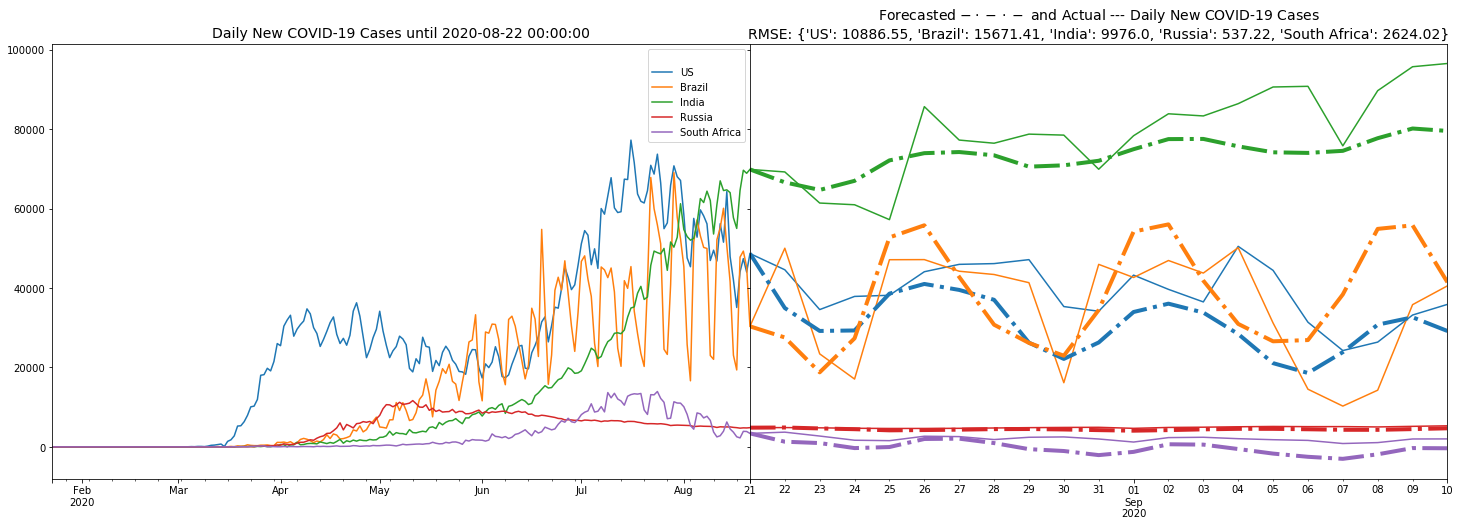

In [7]:
p, num_forecasts = 7, 20

stu_df = load_data()
_, forecasts = var_first_diff(stu_df, p, num_forecasts)
actual = pd.read_pickle("assets/actual_multi.pkl")
rmse = np.sqrt(np.mean((actual - forecasts) ** 2, axis=0)).round(2)

fig, axes = plt.subplots(1, 2, figsize=(25, 8), sharey=True, gridspec_kw={"wspace": 0})

stu_df.plot(ax=axes[0])

stu_df.iloc[-1:].append(actual).plot(ax=axes[1], legend=False)
axes[1].set_prop_cycle(None)

stu_df.iloc[-1:].append(forecasts).plot(ax=axes[1], legend=False, style=["-."] * stu_df.shape[-1], linewidth=4)

axes[0].set_title(f"Daily New COVID-19 Cases until {forecasts.index[0]}", fontsize=14)
axes[1].set_title(r"Forecasted $-\cdot-\cdot-$ and Actual --- Daily New COVID-19 Cases" + "\n" + f"RMSE: {rmse.to_dict()}", fontsize=14)

del fig, axes, stu_df, p, num_forecasts, forecasts, actual, rmse

### Question 1b (10 pts)

Now, let's compare the forecasts made by the $\mathrm{VAR(p)}$ model you trained above with that made by five independent $\mathrm{AR(p)}$ models for each time series. This way, we will be able to see the effect of including observations from possibly related time series on modelling each invidual time series more clearly. 

Complete the function below that uses the `arma_first_diff` function you wrote in **Assignment 3 Part 1** to fit five $\mathrm{AR}(p)$ models, one time series each, and make forecasts for each of the five time series. Return the forecasts as a `pd.DataFrame`. 

For example, when parameter `num_forecasts=20`, the forecasts should be a `pd.DataFrame` like the following:

| | ? | ? | ? | ? | ? |
|-: | -: | -: | -: | -: | -: |
|**2020-08-22**|37606.337737|30054.801607|65293.198373|4799.898341|2613.269306|
|**2020-08-23**|34659.880538|21722.458140|60235.575280|4795.226196|2096.298645|
|**2020-08-24**|31822.923153|24670.815522|64022.272121|4773.476292|1556.778499|
|**...**|...|...|...|...|...|
|**2020-09-08**|36489.857891|41764.328105|73674.836876|4767.958973|2249.096891|
|**2020-09-09**|38427.089594|44335.452439|74071.644729|4767.761722|2587.726648|
|**2020-09-10**|39442.677738|39179.959665|71831.680217|4767.538096|2503.294019|

where
* the index of the DataFrame is a `pd.DatetimeIndex`; 
* the column names "?" are the top 5 countries with the most cumulative cases as of August 21, 2020, sorted in descending order from left to right;
* the values of the DataFrame are the forecasts; and
* the DataFrame doesn't contain any `NaN` values. 

**This function should return a `pd.DataFrame` of shape `(num_forecasts, 5)` representing the forecasts.**

In [8]:
# Copy and paste the function you wrote in Assignment 3 Part 1
from statsmodels.tsa.arima.model import ARIMA



def arma_first_diff(ser, p, q, num_forecasts):
    """
    Takes a series and fits an ARMA(p, q) model on first-order diff. 
    Returns a number of forecasts as specified by num_forecasts. 
    """
    
    
    order = (p, 1, q)

    
    forecasts = ARIMA(ser, order = order)
    
    forecast_fit = forecasts.fit()
    forecasts =  forecast_fit.forecast(num_forecasts)

    

    
    return forecasts


In [9]:
def ar_first_diff(df, p, num_forecasts):
    """
    Fits an AR(p) model on the first-order diff on each time series in df and makes num_forecasts forecasts
    """
    
    dataframe = df
    
    US_Series = dataframe['US']
    Brazil_Series = dataframe['Brazil']
    India_Series = dataframe['India']
    Russia_Series = dataframe['Russia']
    South_Africa_Series = dataframe['South Africa']
    
    US_Series_AR = arma_first_diff(US_Series, p=p, num_forecasts = num_forecasts, q=0)
    Brazil_Series_AR = arma_first_diff(Brazil_Series, p=p, num_forecasts = num_forecasts, q=0)
    India_Series_AR = arma_first_diff(India_Series, p=p, num_forecasts = num_forecasts, q=0)
    Russia_Series_AR = arma_first_diff(Russia_Series, p=p, num_forecasts = num_forecasts, q=0)
    South_Africa_Series_AR = arma_first_diff(South_Africa_Series, p=p, num_forecasts = num_forecasts, q=0)
    
    country_dict = {'US':US_Series_AR, 'Brazil':Brazil_Series_AR, 'India':India_Series_AR, 'Russia':Russia_Series_AR, 'South Africa':South_Africa_Series_AR}
        
    forecasts = pd.DataFrame(country_dict, columns=['US', 'Brazil', 'India', 'Russia', 'South Africa'])
    
    
    
    return forecasts


In [10]:
# Autograder tests

stu_df = load_data()
p, num_forecasts = 7, 20
stu_ans = ar_first_diff(stu_df, p, num_forecasts)

assert isinstance(stu_ans, pd.DataFrame), "Q1b: Your forecasts should be a pd.DataFrame. "
assert stu_ans.shape == (num_forecasts, stu_df.shape[-1]), "Q1b: The shape of your forecasts returned is incorrect. "
assert isinstance(stu_ans.index, pd.DatetimeIndex), "Q1b: The index of your forecasts must be a pd.DatetimeIndex. "
assert (("2020-08-22" <= stu_ans.index) & (stu_ans.index <= "2020-09-10")).all(), "Q1b: The index of your forecasts contains an incorrect time range. "
assert not stu_ans.isna().any(axis=None), "Q1b: Your forecasts contain NaN values. "
assert stu_ans.dtypes.apply(lambda x: np.issubdtype(x, np.floating)).all(), "Q1b: All columns of your forecasts should have a float dtype. "

# Some hidden tests


del stu_ans, stu_df, p, num_forecasts

We can of course plot the forecasts made by the five $\mathrm{AR}(p)$ models. How does the RMSE for each time series compare with that calculated from the forecasts made by a single $\mathrm{VAR}(p)$ model? 

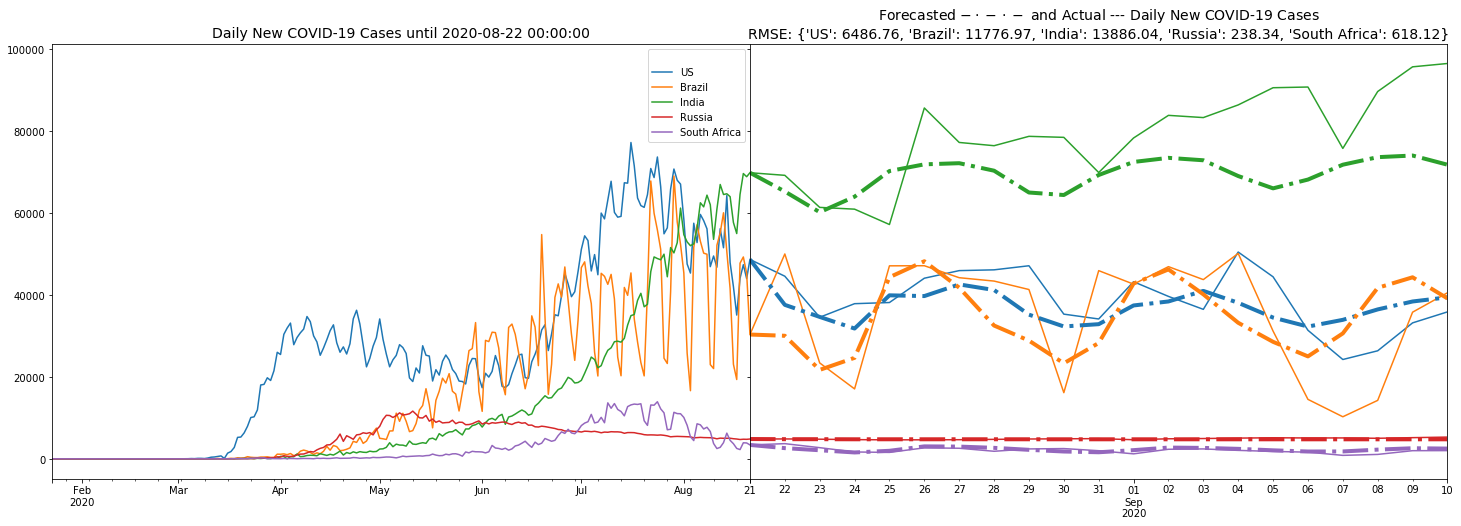

In [11]:
p, num_forecasts = 7, 20

stu_df = load_data()
forecasts = ar_first_diff(stu_df, p, num_forecasts)
actual = pd.read_pickle("assets/actual_multi.pkl")
rmse = np.sqrt(np.mean((actual - forecasts) ** 2, axis=0)).round(2)

fig, axes = plt.subplots(1, 2, figsize=(25, 8), sharey=True, gridspec_kw={"wspace": 0})

stu_df.plot(ax=axes[0])

stu_df.iloc[-1:].append(actual).plot(ax=axes[1], legend=False)
axes[1].set_prop_cycle(None)

stu_df.iloc[-1:].append(forecasts).plot(ax=axes[1], legend=False, style=["-."] * stu_df.shape[-1], linewidth=4)

axes[0].set_title(f"Daily New COVID-19 Cases until {forecasts.index[0]}", fontsize=14)
axes[1].set_title(r"Forecasted $-\cdot-\cdot-$ and Actual --- Daily New COVID-19 Cases" + "\n" + f"RMSE: {rmse.to_dict()}", fontsize=14)

del fig, axes, stu_df, p, num_forecasts, forecasts, actual, rmse

## Question 2: Granger Causality (15 pts)

By comparing the forecasts made by a single $\mathrm{VAR}(p)$ model and by five independent $\mathrm{AR}(p)$ models above, you may notice that the RMSE of one country has improved after we "upgrade" an $\mathrm{AR}(p)$ model to include observations from all other time series. It alerts us about the possible *causality* that may exist among these time series, because the inclusion of some other time series enables us to make better forecasts on another one. 

This is exactly the principle behind Granger Causality test, a statistical test for causality that works by determining whether the inclusion of one time series significantly improves the prediction of the other. Let's now perform a Granger Causality test on each pair of countries and see what we can conclude. 

Complete the function below that first fits a $\mathrm{VAR}(p)$ model on the **first-order differences** of the input `pd.DataFrame` and that then performs a pairwise Granger Causality test **based on F-test** for all possible pairs of the five countries (excluding the pairs formed by a country and itself). The function should return the $p$-value of each pairwise test in a `pd.DataFrame` like the following:

| | ? | ? | ? | ? | ? |
|-: | -: | -: | -: | -: | -: |
|**?**|NaN|1.234348e-05||||
|**?**|6.323140e-01|NaN||||
|**?**|||NaN|||
|**?**||||NaN||
|**?**|||||NaN|

where
* the index and the column names "?" are the top 5 countries with the most cumulative cases as of August 21, 2020, sorted in descending order from top to bottom and from left to right; and
* **each row represents the *caused* variable and each column represents the *causing* variable**

For example, `1.234348e-05` is the $p$-value of the F-test performed to test the null hypothesis that the daily new cases in the Rank 1 country is not *caused by* that in the Rank 2 country. Notice that the "caused-by" relation is not symmetric, so the `pd.DataFrame` above is not symmetric either. You may use the `test_causality` function of either `VARResults` or `VARResultsWrapper` class to perform Granger Causality tests. 

**This function should return a ``pd.DataFrame`` of the shape `(5, 5)`, representing the $p$-value matrix for all pairwise Granger Causality tests.**

In [12]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults, VARResultsWrapper
from statsmodels.tsa.stattools import grangercausalitytests



def test_causality(country_name):
    df = load_data()
    df = var_first_diff(df, p=7, num_forecasts=20)
    df = df[0]
    countries = ['US', 'Brazil', 'India', 'Russia', 'South Africa']
    country_list = []
    country_list = [df.test_causality(country_name, country).pvalue for country in countries]
    return country_list


def test_granger(df, p):
    """
    Fits a VAR(p) model on the input df and performs pairwise Granger Causality tests
    """
    US_list = test_causality('US')
    US_list[0] = None
    Brazil_list = test_causality('Brazil')
    Brazil_list[1] = None
    India_list = test_causality('India')
    India_list[2] = None
    Russia_list = test_causality('Russia')
    Russia_list[3] = None
    South_Africa_list = test_causality('South Africa')
    South_Africa_list[4] = None
    
    country_dict = {'US':US_list, 'Brazil':Brazil_list, 'India':India_list, 'Russia':Russia_list, 'South Africa':South_Africa_list}
    granger_df = pd.DataFrame(country_dict, columns=['US', 'Brazil', 'India', 'Russia', 'South Africa'], index = ['US', 'Brazil', 'India', 'Russia', 'South Africa'])
    granger_df = granger_df.T
    
    return granger_df

In [13]:
# Autograder tests

stu_df, p = load_data(), 7
stu_ans = test_granger(stu_df, 7)

assert isinstance(stu_ans, pd.DataFrame), "Q2: Your function should return a pd.DataFrame. "
assert stu_ans.shape == (5, 5), "Q2: The shape of your pd.DataFrame is not correct. "
assert (stu_ans.index == stu_ans.columns).all(), "Q2: Your pd.DataFrame should have the same index and column labels. "
assert stu_ans.dtypes.apply(lambda x: np.issubdtype(x, np.floating)).all(), "Q2: All columns of your pd.DataFrame should have a float dtype. "

# Some hidden tests


del stu_df, stu_ans, p

If we believe in the magic threshold of $0.01$ (or $0.05$) for rejecting null hypotheses, we will obtain the following "causality matrix". 

In [14]:
# Show the causality matrix

stu_df, p = load_data(), 7
stu_ans = test_granger(stu_df, 7)
caul_mtrx = stu_ans.rename(index={item: f"{item} caused by" for item in stu_ans.index})
caul_mtrx.where(caul_mtrx.isna(), caul_mtrx <= 0.01)

,US,Brazil,India,Russia,South Africa
US caused by,NaN,True,False,False,False
Brazil caused by,False,NaN,True,False,True
India caused by,False,True,NaN,False,True
Russia caused by,True,False,False,NaN,False
South Africa caused by,False,False,False,False,NaN


What do you think about the causality matrix above? Are there any surprising conclusions? Do you believe in the Granger Causality test we just performed? Why or why not? 